# Project 2

##### import needed packages

In [1]:
from tqdm import tqdm_notebook, tqdm, tnrange
from collections import defaultdict,Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from random import shuffle
import matplotlib.pyplot as plt
from datetime import datetime
np.set_printoptions(threshold=np.nan)

Global for enabling GPU

In [2]:
run_gpu = torch.cuda.is_available()
# run_gpu = False
run_gpu

True

# Classes and Functions

## Data Manipulation

### Cleaning and preprocessing

In [3]:
def preprocess(train_data, val_data, test_data, vocab_size=10000):
    
    # loop over all the given files
    for data in [train_data, val_data, test_data]:
        # contains a source and a target file
        for k,v in data.items():
            tokenized_path = v[:v.find('.')] + '_tokenized.{}'.format(k)

            # Tokenize 
            tokenize_command = 'perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l {lang} < {file_path} > {output_path}'.format(
                lang=k, file_path=v, output_path=tokenized_path)
            print('tokenize command:\t{}'.format(tokenize_command))
            
            # Lowercase
            lowercase_path = tokenized_path[:tokenized_path.find('.')] + '_lowercased.{}'.format(k)
            lowercase_command = 'perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < {file_path} > {output_path}'.format(
                file_path=tokenized_path, output_path=lowercase_path)
            print('lowercase command:\t{}\n'.format(lowercase_command))
            
    # BPE
    # Get vocabulary using train data
    script_name = 'python tools/subword-nmt/subword_nmt/learn_joint_bpe_and_vocab.py'
    args = ' --input {train_en} {train_fr} -s {num_symbols} -o {codes_file} --write-vocabulary {vocab_file}.en {vocab_file}.fr'
    substr_index = train_data['en'].find('/')
    vocab_file_name = train_data['en'][:substr_index] + '/vocab'
    codes_file_name = train_data['en'][:substr_index] + '/codes.bpe'
    learn_vocab_command = script_name + args.format(
        train_en='data/train/train_tokenized_lowercased.en',
        train_fr='data/train/train_tokenized_lowercased.fr',
        num_symbols=str(vocab_size),
        codes_file=codes_file_name,
        vocab_file=vocab_file_name
    )
    print('learn vocab command:\t{}'.format(learn_vocab_command))
    
    # Process all files the same way for consistency
    script_name = 'python tools/subword-nmt/subword_nmt/apply_bpe.py'
    for data in [train_data, val_data, test_data]:
        for k,v in data.items():
            args = ' -c {codes_file} --vocabulary {vocab_file}.{lang} --vocabulary-threshold 50 < {train_file}.{lang} > {train_file}_bpe.{lang}'
            train_file_name = v[:v.find('.')] + '_tokenized_lowercased'
            bpe_command = script_name + args.format(
                codes_file=codes_file_name,
                vocab_file=vocab_file_name,
                lang=k,
                train_file=train_file_name
            )
            print('bpe command:\t{}'.format(bpe_command))

### Building dictionaries and vocabularies

In [4]:
PAD = '<PAD>'
UNK = '<UNK>'
START = '<SOS>'
END = '<EOS>'

In [5]:
class DataProcessor():
    def __init__(self, file_name, vocab_size):
        self.max_sentence_length = -1
        self.vocab_size = vocab_size
        
        self.file_name = file_name
        self.sentences = self.load_data()
        self.vocab,self.vocab_size = self.build_vocab()
        self.w2i, self.i2w = self.build_dicts()        
        
    def load_data(self):
        sentences = []
        with open(self.file_name, 'r') as f:
            for line in f:
                sentences.append(line.split())                
        return sentences
    
    def build_dicts(self):
        """
        creates lookup tables to find the index given the word 
        and the otherway around 
        """
        w2i = defaultdict(lambda: w2i[UNK])
        i2w = dict()
        for i,w in enumerate(self.vocab):
            i2w[i] = w
            w2i[w] = i
        return w2i, i2w    
    
    def build_vocab(self): 
        """
        builds a vocabulary with the most occuring words, in addition to
        the UNK token at index 1 and PAD token at index 0. 
        START and END tokens are added to the vocabulary through the
        preprocessed sentences.
        with vocab size none, all existing words in the data are used
        """
        vocab = Counter()
        for s in self.sentences:
            l = len(s)
            if l > self.max_sentence_length:
                self.max_sentence_length = l
            for w in s:
                vocab[w] += 1

        vocab = [k for k,_ in vocab.most_common(self.vocab_size)]
        vocab = [PAD,UNK,START,END] + vocab
        return vocab,len(vocab)

### Getting data batches

In [6]:
def batch_generator(source_processor, target_processor, batch_size):
    idx = np.arange(len(source_processor.sentences))
    
    if batch_size == 1:
        bi = 0
        while True:
            b_words_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
            b_positions_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
            b_words_target = np.zeros([batch_size, target_processor.max_sentence_length+2])
            
            sent_source = source_processor.sentences[bi] + [END]
            sent_target = [START] + target_processor.sentences[bi] + [END]
                
            b_words_source[0, :len(sent_source)] = np.array([source_processor.w2i[w] for w in sent_source])
            b_positions_source[0, :len(sent_source)] = np.array([i for i in range(len(sent_source))])
            b_words_target[0, :len(sent_target)] = np.array([target_processor.w2i[w] for w in sent_target])
            
            if run_gpu:
                word_tens = torch.from_numpy(b_words_source).type(torch.cuda.LongTensor)
                pos_tens = torch.from_numpy(b_positions_source).type(torch.cuda.LongTensor)
                tar_tens = torch.from_numpy(b_words_target).type(torch.cuda.LongTensor)
                sentence_lengths_source = torch.cuda.FloatTensor([len(sent_source)])
                sentence_lengths_target = torch.cuda.FloatTensor([len(sent_target)])
            else:
                word_tens = torch.from_numpy(b_words_source).type(torch.LongTensor)
                pos_tens = torch.from_numpy(b_positions_source).type(torch.LongTensor)
                tar_tens = torch.from_numpy(b_words_target).type(torch.LongTensor)
                sentence_lengths_source = torch.FloatTensor([len(sent_source)])
                sentence_lengths_target = torch.FloatTensor([len(sent_target)])
                
            bi += 1
            if bi == len(source_processor.sentences):
                bi = 0
            yield (word_tens,
                   pos_tens,
                   tar_tens,
                   sentence_lengths_source,
                   sentence_lengths_target,
                   np.ones(sentence_lengths_source[0]),
                   np.ones(sentence_lengths_target[0]))
    
    else:
        while True:
            shuffle(idx)
            batch_idx = [idx[i:i + batch_size] for i in range(0, len(idx) - (len(idx)%batch_size), batch_size)]
            
            for b_idx in batch_idx:
                b_words_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
                b_positions_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
                b_words_target = np.zeros([batch_size, target_processor.max_sentence_length+2])

                sentence_lengths_source = []
                sentence_lengths_target = []
                for i, bi in enumerate(b_idx):
                    sent_source = source_processor.sentences[bi] + [END]
                    sent_target = [START] + target_processor.sentences[bi] + [END]

                    b_words_source[i, :len(sent_source)] = np.array([source_processor.w2i[w] for w in sent_source])
                    b_positions_source[i, :len(sent_source)] = np.array([i for i in range(len(sent_source))])
                    b_words_target[i, :len(sent_target)] = np.array([target_processor.w2i[w] for w in sent_target])

                    sentence_lengths_source.append(len(sent_source))
                    sentence_lengths_target.append(len(sent_target))
                    
                max_len_source = np.max(sentence_lengths_source)
                max_len_target = np.max(sentence_lengths_target)
                if run_gpu:
                    word_tens = torch.from_numpy(b_words_source).type(torch.cuda.LongTensor)
                    pos_tens = torch.from_numpy(b_positions_source).type(torch.cuda.LongTensor)
                    tar_tens = torch.from_numpy(b_words_target).type(torch.cuda.LongTensor)
                    sentence_lengths_source = torch.cuda.FloatTensor(sentence_lengths_source)
                    sentence_lengths_target = torch.cuda.FloatTensor(sentence_lengths_target)
                    source_mask = torch.from_numpy((b_words_source > 0).astype(int)).type(torch.cuda.FloatTensor)
                    target_mask = torch.from_numpy((b_words_target > 0).astype(int)).type(torch.cuda.LongTensor)
                else:
                    word_tens = torch.from_numpy(b_words_source).type(torch.LongTensor)
                    pos_tens = torch.from_numpy(b_positions_source).type(torch.LongTensor)
                    tar_tens = torch.from_numpy(b_words_target).type(torch.LongTensor)
                    sentence_lengths_source = torch.FloatTensor(sentence_lengths_source)
                    sentence_lengths_target = torch.FloatTensor(sentence_lengths_target)
                    source_mask = torch.from_numpy((b_words_source > 0).astype(int)).type(torch.FloatTensor)
                    target_mask = torch.from_numpy((b_words_target > 0).astype(int)).type(torch.LongTensor)

                yield (word_tens,
                       pos_tens,
                       tar_tens,
                       sentence_lengths_source,
                       sentence_lengths_target,
                       source_mask,
                       target_mask)

## Sequence 2 Sequence RNN's

### Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, source_vocab_size, source_max_length, embeddings_dim):
        super().__init__()        
        self.word_embeddings = nn.Embedding(source_vocab_size, embeddings_dim)
        self.pos_embeddings = nn.Embedding(source_max_length, embeddings_dim)
        
    def forward(self, words_batch, pos_batch, sentence_lengths, mask): # all inputs are tensors
        words_emb = self.word_embeddings(words_batch)
        pos_emb = self.pos_embeddings(pos_batch)
        full_emb = torch.add(words_emb,pos_emb)
        mean_emb = full_emb.mul(mask.unsqueeze(2).expand_as(full_emb)).sum(dim=1).float()
        mean_emb = mean_emb.div(sentence_lengths.float().view(-1,1)) # batched version of torch.mean(full_emb,1)
        return full_emb, mean_emb

### Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size, embeddings_dim, dropout_p=0.1):
        super().__init__()
        
        self.embedding_dim = embedding_dims
        self.dropout_p = dropout_p
        
        self.target_embeddings = nn.Embedding(target_vocab_size, embeddings_dim)
        self.gru = nn.GRU(embeddings_dim*2, embeddings_dim, batch_first=True) # gru is an LSTM, and has 2 outputs
        self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(embeddings_dim, target_vocab_size)
        
    def forward(self, gold_words_batch, hidden_batch, stacked_encoded_words_batch):
        batch_size = gold_words_batch.size(0)
        encoded_length = stacked_encoded_words_batch.size(1)
        
        emb = self.target_embeddings(gold_words_batch)
        emb = self.dropout(emb)
        
        # attention            
        alphas = torch.zeros(batch_size, encoded_length)
        alphas = hidden_batch.view(batch_size,1,self.embedding_dim).bmm(
            stacked_encoded_words_batch.view(batch_size,self.embedding_dim,encoded_length)) # batched version of dot product
        
        # Turn to probability distribution
        alphas = F.softmax(alphas, dim=2)
            
        # context is weights x hidden states from encoder
        context = torch.bmm(alphas, stacked_encoded_words_batch)
        
        # we have to concat context + emb        
        input = torch.cat((emb, context), 2)
        del(context)
        
        gru_output, hidden = self.gru(input, hidden_batch.view(1, batch_size, self.embedding_dim))
        
        output = self.out(gru_output)
#         output = F.log_softmax(output, dim=2)        
        
        return output, hidden, alphas

### Encoder Decoder

In [16]:
class EncoderDecoder(nn.Module):
    def __init__(self, 
                 embeddings_dim,
                 source_vocab_size, 
                 source_max_length, 
                 target_vocab_size, 
                 dropout_p=0.1):
        
        super().__init__()
        
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        
        self.encoder = Encoder(source_vocab_size,
                               source_max_length + 1, 
                               embeddings_dim)
        self.decoder = Decoder(target_vocab_size, 
                               embeddings_dim,
                               dropout_p=dropout_p)
#         self.loss = nn.NLLLoss(ignore_index=0)
        self.loss = nn.CrossEntropyLoss(ignore_index=0, reduce=False) # weight would be all ones except one, which is identical to ignore_index

        if run_gpu:
            self.encoder = self.encoder.cuda()
            self.decoder = self.decoder.cuda()
            self.loss = self.loss.cuda()

    def forward(self, 
                words_batch_source,
                pos_batch_source,
                sentence_length_source,
                words_batch_target,
                sentence_lengths_target,
                source_mask,
                target_mask):        
        # Encode
        all_embs, hidden_state_batch = self.encoder(words_batch_source, 
                                                    pos_batch_source, 
                                                    sentence_length_source, 
                                                    source_mask)
        
#         #clean up
#         del(words_batch_source)
#         del(pos_batch_source)
#         del(sentence_length_source)
        
        # Decode
        batch_size,max_sent_len = words_batch_target.shape
        out = torch.zeros((batch_size))
        if run_gpu:
            out = out.cuda()
        for w_idx in range(max_sent_len-1):
            prediction, hidden_state_batch, _ = self.decoder(words_batch_target[:,w_idx].view(-1,1), 
                                                          hidden_state_batch,
                                                          all_embs)
            out += self.loss(prediction.squeeze(1), words_batch_target[:,w_idx+1])        
        #cleanup
        del(all_embs)
        del(prediction)
        del(hidden_state_batch)
#         del(words_batch_target)
        out = torch.mean(torch.div(out,sentence_lengths_target))  # the loss is the average of losses, so divide over number of words in each sentence
#         del(sentence_lengths_target)
        return out

# Running the Code

## Define Hyper Parameters

#### files

In [17]:
# Raw
train_data = {'en': 'data/train/train.en', 'fr': 'data/train/train.fr'}
val_data = {'en': 'data/val/val.en', 'fr': 'data/val/val.fr'}
test_data = {'en': 'data/test/test_2017_flickr.en', 'fr': 'data/test/test_2017_flickr.fr'}

# Preprocessed
source_train_file = 'data/train/train_tokenized_lowercased_bpe.fr'
target_train_file = 'data/train/train_tokenized_lowercased_bpe.en'
source_val_file = 'data/val/val_tokenized_lowercased_bpe.fr'
target_val_file = 'data/val/val_tokenized_lowercased_bpe.en'
source_test_file = 'data/test/test_2017_flickr_tokenized_lowercased_bpe.fr'
target_test_file = 'data/test/test_2017_flickr_tokenized_lowercased_bpe.en'

#### Network Parameters

In [18]:
learning_rate = 1e-3
max_epochs = 30
batch_size = 256

source_vocab_size = 30000
target_vocab_size = 30000
hidden_dims = 128
embedding_dims = 128

save_step = 100

## process data

perform the preprocessing

In [19]:
preprocess(train_data, val_data, test_data, source_vocab_size)

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l en < data/train/train.en > data/train/train_tokenized.en
lowercase command:	perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < data/train/train_tokenized.en > data/train/train_tokenized_lowercased.en

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l fr < data/train/train.fr > data/train/train_tokenized.fr
lowercase command:	perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < data/train/train_tokenized.fr > data/train/train_tokenized_lowercased.fr

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l en < data/val/val.en > data/val/val_tokenized.en
lowercase command:	perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < data/val/val_tokenized.en > data/val/val_tokenized_lowercased.en

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l fr < data/val/val.fr > data/val/val_tokenized.fr
lowercase command:	perl tool

prepare data for the model

In [20]:
source_processor = DataProcessor(source_train_file, source_vocab_size)
target_processor = DataProcessor(target_train_file, target_vocab_size)

## setup the Network

In [21]:
encdec = EncoderDecoder(embedding_dims, 
                        source_processor.vocab_size,
                        source_processor.max_sentence_length,
                        target_processor.vocab_size)

if run_gpu:
    encdec = encdec.cuda()
opt = Adam(encdec.parameters(), lr=learning_rate)

bla


## training

In [22]:
####### Remove this
# max_epochs = 5
# batch_size = 4
###########

losses = []
count = 0
gen = batch_generator(source_processor, target_processor, batch_size)
sentences_in_data = len(source_processor.sentences)
iterations = int(np.ceil(sentences_in_data/batch_size)*max_epochs)
        
for it in tnrange(iterations): 
    output_i = it%save_step
    out = 0
    if output_i == 0:
        if it != 0:
            losses += output.tolist()
            del(output)
        if run_gpu:
            output = torch.cuda.FloatTensor([0]*save_step)
        else:
            output = torch.FloatTensor([0]*save_step)
    
    opt.zero_grad()
    
    # Get the next bath of data and 
    words_batch_source, pos_batch_source, words_batch_target, sentence_lengths_source, sentence_lengths_target, source_mask, target_mask = next(gen)
    
    out = encdec(words_batch_source,
                 pos_batch_source, 
                 sentence_lengths_source, 
                 words_batch_target, 
                 sentence_lengths_target, 
                 source_mask, 
                 target_mask)
    
    out.backward()
    output[output_i] = out
    opt.step()
    count += batch_size
    if count >= sentences_in_data:
        count = 0
        # Dump trained models
        timestamp = datetime.now()
        torch.save(encdec.state_dict(), 'model_it_{}_t_{:%m_%d_%H_%M}.torchsave'.format(it, timestamp))
losses += output.tolist()[:output_i+1]
del(output)

# Dump trained models
timestamp = datetime.now()
torch.save(encdec.state_dict(), 'model_last-it_{}_t_{:%m_%d_%H_%M}.torchsave'.format(it, timestamp))

In [23]:
# print('run_gpu:\t\t| '+str(run_gpu))
# print('=====================================')
# print('words_batch_source:\t| ' +str(words_batch_source.is_cuda))
# print('pos_batch_source:\t| '   +str(pos_batch_source.is_cuda))
# print('words_batch_target:\t| ' +str(words_batch_target.is_cuda))
# print('sen_len_source:\t\t| '   +str(sen_len_source.is_cuda))
# print('all_embs:\t\t| '         +str(all_embs.is_cuda))
# print('hidden_state_batch:\t| ' +str(hidden_state_batch.is_cuda))
# print('prediction:\t\t| '       +str(prediction.is_cuda))
# print('output:\t\t\t| '         +str(output.is_cuda))
# print('out:\t\t\t| '           +str(out.is_cuda))

In [24]:
# losses2 = [item for sublist in losses for item in sublist]
# losses

Plot losses

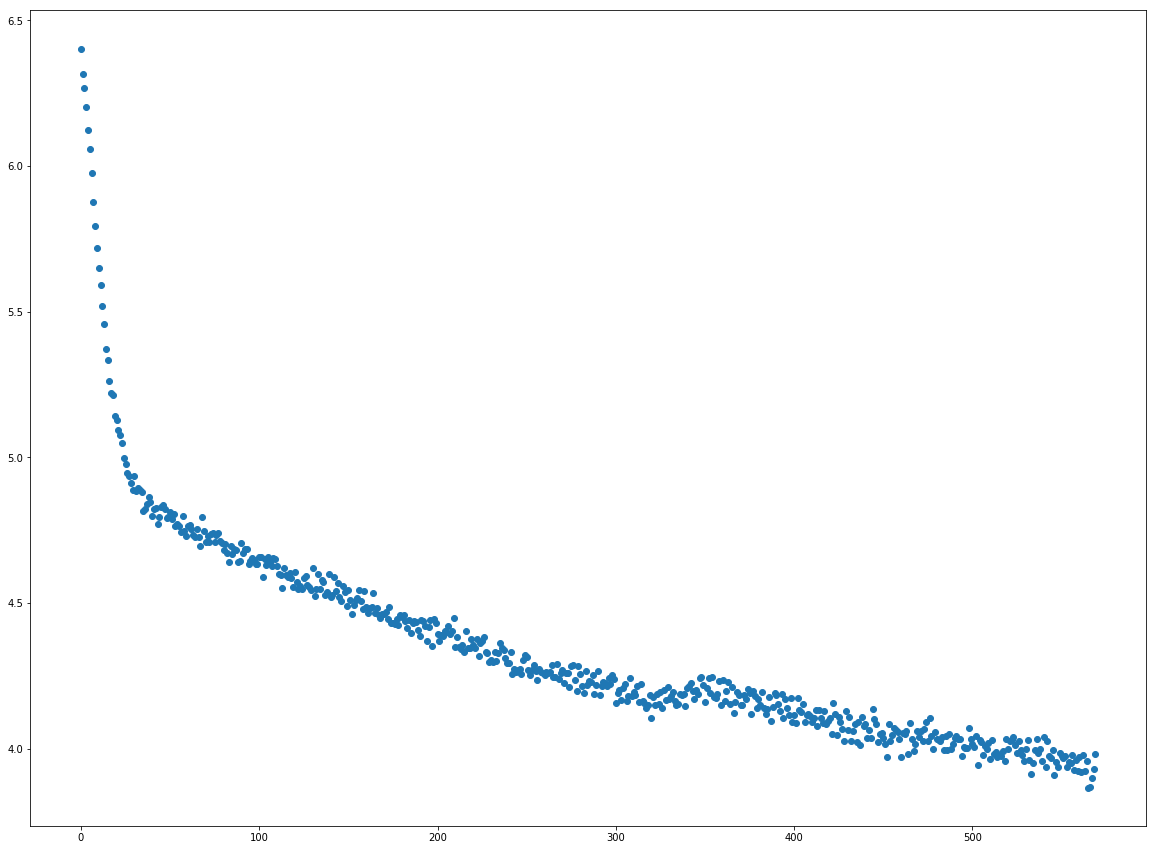

In [25]:

plt.figure(figsize=(20,15))
plt.scatter(range(len(losses)),losses)
y = losses[0:10]
plt.show()

## prediction

load trained models

In [ ]:
# encoder = Encoder(source_processor.vocab_size,
#                   source_processor.max_sentence_length+1, 
#                   embeddings_dim=embedding_dims)
# decoder = Decoder(target_processor.vocab_size, 
#                   embeddings_dim=embedding_dims)

# trained_encoder_file = 'encoder_it_144999_t_05_24_16_31'
# trained_decoder_file = 'decoder_it_144999_t_05_24_16_31'
# encoder.load_state_dict(torch.load(trained_encoder_file))
# decoder.load_state_dict(torch.load(trained_decoder_file))

encdec = EncoderDecoder(embedding_dims,
                        source_processor.vocab_size,
                        source_processor.max_sentence_length,
                        target_processor.vocab_size)

trained_model_file = 'trained_model/initial_batched_run_30pseudo-epochs/encoder_last-it_13619_t_05_25_01_06.torchsave'

saved_state = torch.load(trained_model_file, map_location=lambda storage, loc: storage) # Bring from cuda
encdec.load_state_dict(saved_state)

# Use submodules for prediction
encoder = encdec.encoder
decoder = encdec.decoder

In [ ]:
file_id = trained_model_file[trained_model_file.rfind('/')+1:-3]
prediction_file_name = 'test_{}.pred'.format(file_id)

In [ ]:
source_processor_test = DataProcessor(source_test_file, None)
target_processor_test = DataProcessor(target_test_file, None)

In [ ]:
predicted_sentences = []
attention_weights = [] # list of (source_sentence, predicted_sentence, alphas) items

for s in source_processor_test.sentences:
    mask = torch.from_numpy(np.ones([1,len(s)])).type(torch.FloatTensor)
    words_tokens = torch.LongTensor([source_processor_test.w2i[w] for w in s])
    pos_tokens = torch.LongTensor([i for i in range(len(s))])
    
    # Encode
    all_embs, mean_emb = encoder(words_tokens.view(1, len(s)),
                                 pos_tokens.view(1, len(s)), 
                                 torch.FloatTensor([len(s)]),
                                 mask)
    
    # Decode
    predicted_words = []
    
    start_token = torch.LongTensor([target_processor.w2i[START]])
    prediction = start_token.view(1,1)
    
    hidden_state_batch = mean_emb
    
    for w_idx in range(target_processor.max_sentence_length):# loop until EOS is produced or a max is reached (max_sentence_length)
        prediction, hidden_state_batch, alphas = decoder(
            prediction, # the previous prediction
            hidden_state_batch,
            all_embs)
        
        index_predicted_word = np.argmax(prediction.detach().numpy(), axis=2)[0][0]
        predicted_word = target_processor.i2w[index_predicted_word]
        predicted_words.append(predicted_word)
        
        if predicted_word == END:
            break
            
        prediction = torch.LongTensor([index_predicted_word]).view(1,1)
    
    predicted_sentences.append(predicted_words)
    attention_weights.append((s, predicted_words, alphas.squeeze()[:w_idx].detach().numpy()))
    
with open(prediction_file_name, 'w', encoding='utf-8') as f:
    for p,_ in predicted_sentences:
        if p[-1] == END:
            p = p[:-1]
        f.write(' '.join(p) + '\n')

print('Predictions ready in file: {}'.format(prediction_file_name))

pickles.dump(attention_weights, file_id + '_prediction_weights')

### attention visualization

In [ ]:
# attention_weights = []
# attention_weights.append(('c \' est la premiere ligne'.split(), 'this is the first sentence'.split(), np.random.random([6])))
# attention_weights.append(('c \' est la deuxieme ligne'.split(), 'this is the second sentence'.split(), np.random.random([6])))
# attention_weights.append(('c \' est la troisieme ligne'.split(), 'this is the third sentence'.split(), np.random.random([6])))
# print(attention_weights)

def visualize_attention(source_sentence, target_sentence, weights):
    weights = np.random.random((len(source_sentence), len(target_sentence)))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(weights, cmap='bone')
    fig.colorbar(cax)
    
    ax.set_yticklabels([''] + source_sentence)
    ax.set_xticklabels([''] + target_sentence, rotation=45)
    
#     plt.show()
    plt.savefig('{}_pred'.format(file_id))
    
sentence_id = 0
item = attention_weights[sentence_id]
visualize_attention(item[0], item[1], item[2])

## Evaluation

Restore original segmentation

In [ ]:
prediction_restored = prediction_file_name[:-5] + '_restored.pred'

In [ ]:
# sed -r 's/(@@ )|(@@ ?$)//g' Use the Powershell version instead. Watch for ASCII!

restore_command = 'get-content {input_file} | %{{$_ -replace "(@@ )|(@@ ?$)",""}} | out-file {output_file} -encoding ASCII'.format(
    input_file = prediction_file_name,
    output_file = prediction_restored)

print('restore file command:\t', restore_command)

### BLEU

In [ ]:
bleu_command = 'perl tools/mosesdecoder/scripts/generic/multi-bleu.perl -lc data/test/test_2017_flickr_tokenized_lowercased.en < {} > {}'.format(
    prediction_restored,
    'bleu_results/' + file_id + '.bleu')

print('bleu file command:\t', bleu_command)

### Meteor

In [ ]:
meteor_command = 'java -jar tools/meteor-1.5/meteor-1.5.jar {} data/test/test_2017_flickr_tokenized_lowercased.en > {}'.format(
    prediction_restored,
    'meteor_results/' + file_id + '.meteor')

print('meteor command:\t', meteor_command)

### TER

In [ ]:
# Append ids to both gold and prediction files
gold = 'data/test/test_2017_flickr_tokenized_lowercased.en'
gold_ter = gold[:-3] + '_ter.en'

prediction_restored_ter = prediction_restored[:-5] + '_ter.pred'

with open(gold, 'r') as fi, open(gold_ter, 'w') as fo:
    for i, line in enumerate(fi.readlines()):
        last_char = line[-1]
        fo.write('{} ({}){}'.format(line[:-1], i, last_char))

with open(prediction_restored, 'r') as fi, open(prediction_restored_ter, 'w') as fo:
    for i, line in enumerate(fi.readlines()):
        last_char = line[-1]
        fo.write('{} ({}){}'.format(line[:-1], i, last_char))

In [ ]:
ter_command = 'java -jar tools/tercom-0.7.25/tercom.7.25.jar -r {} -h {} -n {} > {}'.format(
    gold_ter,
    prediction_restored_ter,
    'ter_results/' + file_id,
    'ter_results/' + file_id + '_out.txt')

print('ter command:\t', ter_command)

#### beam search

In [ ]:
class Hypothesis(object):
    """use for decoding"""
    def __init__(self, perm, score, state):
        self.perm = perm
        self.score = score
        self.state = state

    def update(self):
        return

def decode(sent, beam_size):
    """Beam search decoder"""
    """bin: keep track of hypothesis, bin[i] contains all the hypotheses of length i"""
    bin = [] # to keep track of hypothesis

    # first of all, we need to encode the whole source sentence
    # since this is done only one time
    # map word to its id
    fids = map(numberizer.numberize, sent[:-1])
    enc_state = encode(fids)
    """
        enc_state is a computational graph
        it's very expensive to use it during decoding, since the graph will be recomputed each time
        and during decoding, we don't update parameter, so we would like to fix enc_state
        This is done nicely by compute the actual value of enc_state
    """
    enc_state = constant(compute_value(enc_state))  # now it's a constant, accessing time is constant

    """ the output layer also can be precomputed """
    out_layer = encode_birnn(fids)
    out_layer = constant(compute_value(out_layer))  ## turn it to a precomputed big matrix
    """ now we start the decoder with encoder state """
    dec.start(enc_state)
    state0 = dec.step(embeddings[numberizer.numberize("<s>")])
    state0_const = constant(compute_value(state0))
    # create the first hypothesis
    h0 = Hypothesis([-1], 0.0, state0_const)
    # put h0 to bin
    stacks = []
    stacks.append(h0)
    bin.append(stacks)  # note that we put h0 in to a stack first

    # now we can loop through number of source words
    n = len(fids)
    for i in range(n):
        prev_stack = bin[i]
        curr_stack = []
        for hypo in prev_stack:
            # expand it
            # first, reset the decoder state
            dec.start(hypo.state)
            # update decoder state with the previous generated word
            last_id = hypo.perm[-1]  # here it's just the position
            # we get the actual word
            word_id = fids[last_id]
            # then turn it to a vector
            last_inpt = embeddings[word_id]
            # now, update decode
            new_state = dec.step(last_inpt)
            #compute the log output
            log_prob = logsoftmax(dot(out_layer, new_state))
            # actually compute it
            log_prob = compute_value(log_prob)
            # get out top beam_size log prob
            """Add your code here"""
            for j,prob in enumerate(log_prob):
                perm = list(hypo.perm)
                #if not covered yet, extend the permutation
                if(j not in perm):
                    perm.append(j)
                    new_prob = hypo.score + prob
                    new_h = Hypothesis(perm,new_prob,new_state)
                    curr_stack.append(new_h)

        #if there more then 100 permutations, take the top 100
        if len(curr_stack) > beam_size:
            ordered_scores = []
            #get the scores from the hypothesis
            for h in curr_stack:
                ordered_scores.append(h.score)
            #get the indexs from 100 highest scores
            locations = sorted(range(len(ordered_scores)), key=lambda i: ordered_scores[i])[-beam_size:]
            #put top 100 in the bin
            stacks = [curr_stack[i] for i in locations]
            bin.append(stacks)
        else:
            bin.append(curr_stack)

    ordered_scores = []
    last_stack = bin[-1]
    #get the scores from the hypothesis
    for h in last_stack:
        ordered_scores.append(h.score)

    #return the hypothesis with highest score
    return last_stack[ordered_scores.index(max(ordered_scores))].perm[1:]